In [1]:
import matplotlib.pylab as plt
import numpy as np
import scipy.signal as sp
import sys

In [2]:
#Slab class
class Slab:
    def __init__(self, rho, v, d, A):
        self.rho = rho #density kg/m^3
        self.v = v     #velocity m/s
        self.d = d     #thickness m
        self.A = A     #Area m^2
        self.Z = rho * v /A
        
    def k(self,omega):
        return omega/self.v #1/m

#Al = Slab(1, 2, 3)
    

In [3]:
#In the photonics paper they use Z = rho * A * v and in the thesis they use Z = rho * v. 
#The latter gives the expected value for the electromechanical coupling constant


#First create the slab properties

#We choose A to be 1mm^2 for all Slabs
A = np.pi*(118e-6)**2 #m^2

#These properties are from the table in photonics_hbar
Al = Slab(2700, 6300, 0.1e-6, A)
AlN = Slab(3300, 11050, 0.92e-6, A)
Mo = Slab(10200, 6636, 0.1e-6, A)
Ox = Slab(2200,5640,5.44e-6,A)
Si = Slab(2329,8430,231.5e-6,A)

#AlN.kt = 0.065
'''Look at whether we need relative or absolute permitivitty'''
AlN.eps = 8.9 * 8.854187821e-12 
AlN.e = 1.55 #C/m^2
AlN.kt2 = AlN.e**2 / (AlN.Z * AlN.eps * AlN.v)
print(AlN.kt2)

3.3097870378335193e-09


In [4]:
#function to calculate Z_H and Z_L
#See equation in (Photonics_Hbar) to see where these equations come from

#function to find Z_H for a certain frequency
def find_Ztop(omega): #left slab is aluminum (make more general later)
    
    Ztop = 1j * Al.Z * np.tan(Al.k(omega)*Al.d)
    return Ztop

#function to find Z_L for a certain frequency
def find_Zbot(omega):
    
    #First find Z2 
    #splitting up to keep it clear
    numerator = Si.Z * np.tan(Si.k(omega) * Si.d) + Ox.Z * np.tan(Ox.k(omega) * Ox.d)
    denominator = 1 - (Si.Z / Ox.Z) * np.tan(Si.k(omega)*Si.d) * np.tan(Ox.k(omega) * Ox.d)
    Z2 = 1j * numerator / denominator

    
    #Find Zbot
    numerator = Z2 + 1j * Mo.Z * np.tan(Mo.k(omega) * Mo.d)
    denominator = 1 + 1j * (Z2 / Mo.Z) * np.tan(Mo.k(omega) * Mo.d)
    Zbot = numerator / denominator

    return Zbot

In [5]:
#A function which returns the input impedance as a function of omega and ZH and ZL
def find_Z_in(omega): #I could put the last two params somewhere else
    #giving simple variable names
    k = AlN.k(omega)
    d = AlN.d
    C0 = AlN.A * AlN.eps / d
    #C0 = AlN.eps / d
    ztop = find_Ztop(omega) / AlN.Z
    zbot = find_Zbot(omega) / AlN.Z
    
    
    #first calculate prefactor
    prefac = 1/(1j*omega*C0) 
    
    #Calculate the term in numerator
    numerator = (ztop + zbot)*np.sin(k*d) + 2j * (1-np.cos(k*d)) 
    denominator = (ztop + zbot) * np.cos(k*d) + 1j * (1 + zbot*ztop) * np.sin(k*d) 
    
    Z_in = prefac * (1  - (AlN.kt2**2/(k*d)**2/2 * numerator/denominator)) 

    return Z_in 

In [6]:
#function to get s11 again see photonics_hbar notebook
def get_s11(omega,Z0):
    #get z_in for this specific omega using equation above
    Z_in = find_Z_in(omega)
    
    #calculate s11
    #s11 = (np.abs(Z0) - np.abs(Z_in)) / (np.abs(Z0) + np.abs(Z_in))
    s11 = (Z0 - Z_in) / (Z0 + Z_in)
    return s11

In [7]:
%matplotlib notebook

In [8]:
omegas = np.linspace(1e9,6e9,int(1e5))
s11_values = np.zeros(len(omegas)) 
Zin = np.zeros(len(omegas))
Z0 = 50

count =0
for i in range(len(omegas)):
        #get the s11 values
        #s11_values[i] = (np.abs(get_s11(omegas[i],Z0)))
        Zin[i] = (np.abs(find_Z_in(omegas[i])))
        
        #print at every 10% in the range
        if (i%(len(omegas)/100))==0:
            count+=1
            print("loading... ",count, "%", end = "\r")
            
            #print(find_Z_in(omegas[i]))
        #since Z_1 is very small compared to 50 ohm, we get only ones. I have to look at all the quantities sitll..
print("min value we found is", np.min(s11_values))

min value we found is 0.0%


<IPython.core.display.Javascript object>


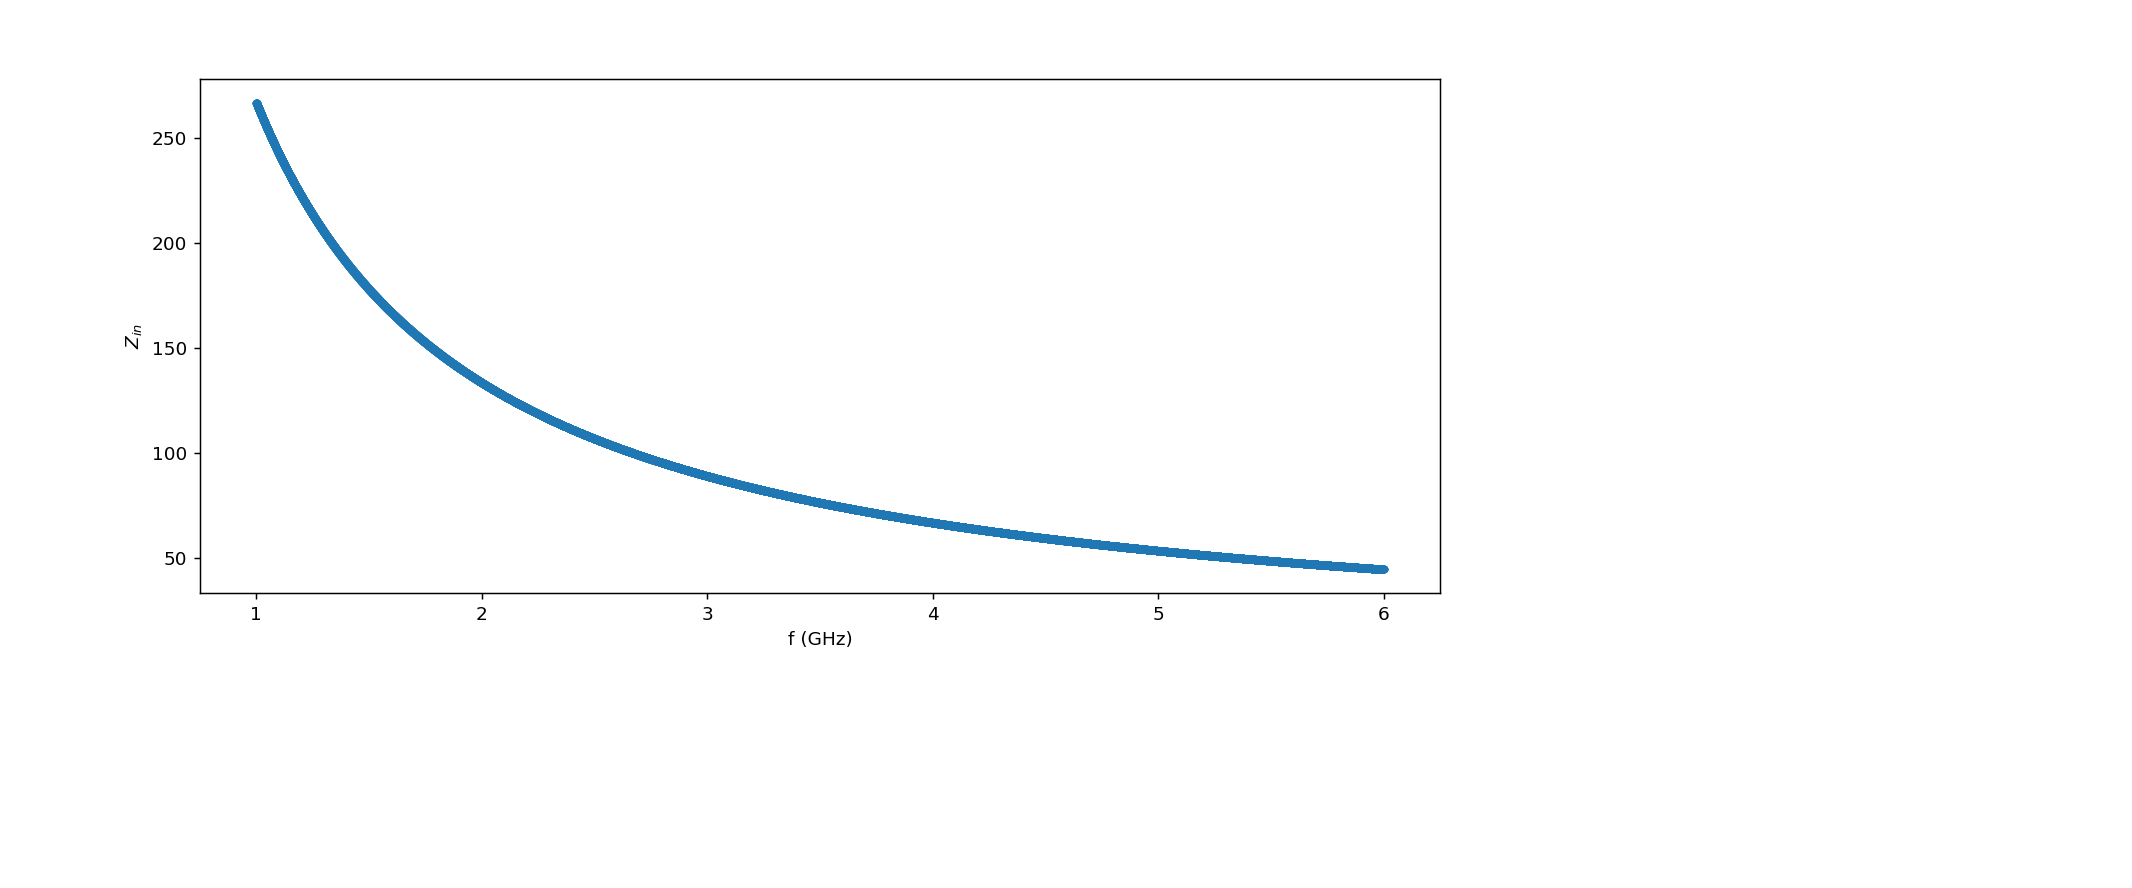

In [9]:
# plt.figure(figsize = (12,5))  
# plt.plot(omegas/1e9,s11_values,ls='none',marker='.')
# plt.ylabel("$s_{11}$ (dB)")
# plt.xlabel("f (GHz)")    
# plt.show()

plt.figure(figsize = (12,5))  
plt.plot(omegas/1e9,Zin,ls='-',marker='.')
plt.ylabel("$Z_{in}$")
plt.xlabel("f (GHz)")    
plt.show()

------------
------------
-----------
------------
------------
# Testing stuff

/Users/samkatiraee-far/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]


<IPython.core.display.Javascript object>


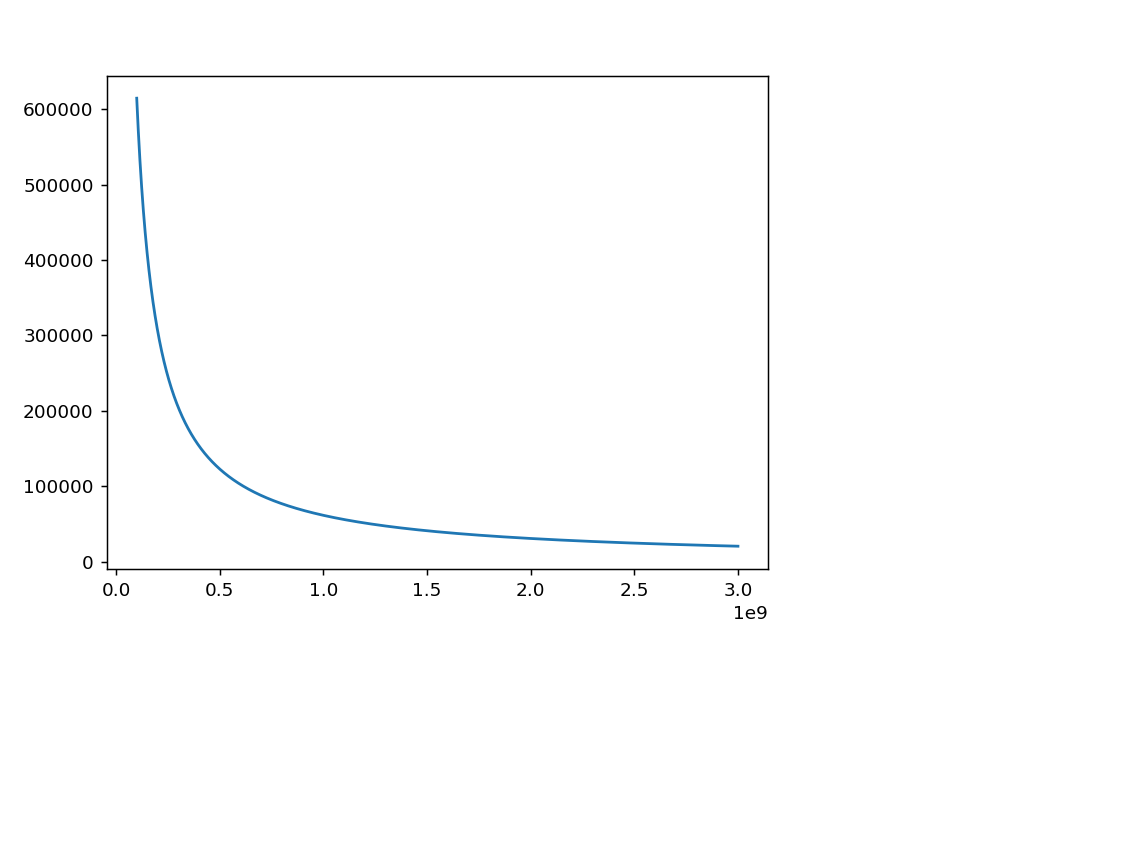

/Users/samkatiraee-far/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [10]:
#other equation
omegas = np.linspace(0.1e9,3e9,int(1e6))
Zin = np.zeros(len(omegas),dtype=complex)
s11 = np.zeros(len(omegas))
d = 250e-6
eps = 10.5 * 8.854187821e-12
C0 = AlN.A *  eps / d
kt2 = 0.065

for i in range(len(omegas)):
    k = AlN.k(omegas[i])
    Zin[i] = 1/(1j*omegas[i]*C0) * (1-AlN.kt2*np.tan(k*d/2)/(k*d/2))
    s11[i] = (50 - Zin[i]) / (50 + Zin[i])
    #print((1-kt**2*np.tan(k*d/2)/(k*d/2)))
    
plt.figure()
plt.plot(omegas,1j*Zin)
plt.show()

# plt.figure()
# plt.plot(omegas,20*np.log10(np.abs(s11)))
# plt.show()